# Zilllow Project - Final Report
By AJ Martinez

In [1]:
# import usual libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import from local libraries
import env
from acquire import get_zillow_data
from prepare import * 

# import tools for modeling
from sklearn.feature_selection import  SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor


import warnings
warnings.filterwarnings('ignore')

## Project Description

We want to be able to predict the property tax assessed values of Single Family Properties that had a transaction during 2017.

We have a model already, but we are hoping to improve it using a fresh perspective.

Because property taxes are assessed at the county level, we would like to know what states and counties these are located in.

## Project Goal

- Find the key drivers of property value for single family properties.

- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

- Construct an ML Regression model that predict propery tax assessed values of Single Family Properties using attributes of the properties.

- Make recommendations on what works or doesn't work in prediction these homes' values.

## Data Acquisition & Preperation

Using the function created acquire Zillow data

In [2]:
df = get_zillow_data()
df.head()

Reading from csv file...


,bedrooms,bathrooms,sqft,tax_value,year_built,fips
0,4.0,3.5,3100.0,1023282.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,1950.0,6037.0


The min and max on square footage, tax value, bathrooms and bedrooms are extreme. 
- It is unlikely a single family home would require 14 bedrooms or 18 bathrooms. On the opposite end, it is likely that you would require more than 0. 
- A house with 21,929 sq ft is also way to big for a single family home. On the min 128 sq ft is not enough to call it a house. 
- Values are also pretty absurd at 1000 for min and 49 million for the max. 
- We must remove outliers to get a better idea of what is available.

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,52441.0,3.300681,0.949094,0.0,3.0,3.0,4.00,14.0
bathrooms,52441.0,2.299403,1.022772,0.0,2.0,2.0,3.00,18.0
sqft,52359.0,1922.890754,1004.365838,128.0,1268.0,1659.0,2306.00,21929.0
tax_value,52440.0,529688.163921,751894.553363,1000.0,193747.5,373612.0,619301.25,49061236.0
year_built,52325.0,1963.393884,23.133571,1878.0,1950.0,1961.0,1979.00,2016.0
fips,52441.0,6049.132149,21.029067,6037.0,6037.0,6037.0,6059.00,6111.0


Removing outliers using function

In [4]:
df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'sqft', 'tax_value'])


Number of observations removed: 5670


This numbers look better!
- Bedrooms min is 2 and max of 5, that is a better range for a house
- Bathrooms 1.5 and 4.5 that is also much like a single family home
- Sq ft min as 152 is a bit small still but the max at 3863 is better
- Tax value of 1000 is still a bit low, but 1.2 million is a better number 

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,46771.0,3.229544,0.798486,2.0,3.0,3.0,4.00,5.0
bathrooms,46771.0,2.135330,0.757525,1.0,2.0,2.0,3.00,4.5
sqft,46767.0,1738.369513,650.795133,152.0,1248.0,1593.0,2111.00,3863.0
tax_value,46770.0,388250.607783,263242.063024,1000.0,178569.0,344151.5,539005.25,1256879.0
year_built,46741.0,1962.540874,22.071375,1878.0,1950.0,1960.0,1977.00,2016.0
fips,46771.0,6049.258151,21.246155,6037.0,6037.0,6037.0,6059.00,6111.0


Now we can split the data for exploration

In [6]:
train, validate, test = split_zillow_data(df)

Dataframe has been split: 
Train: (26076, 6)
Validate: (11176, 6)
Test: (9313, 6)


## Data Exploration

We can take a look at the following charts and see what are the relationships.

Looking at the heatmap:
- The highest realtion is bathrooms to sqft
- Tax value highest relation is with sqft and bathrooms
- We can assume that the more bathrooms are available the house would have more room for guests or family members

Looking at the pairplot:
- There is a high number of 3 bedrooms and 2 bathrooms
- High number of houses built in 1950-1970
- Majority of houses are between 1k and 2k sq. ft.

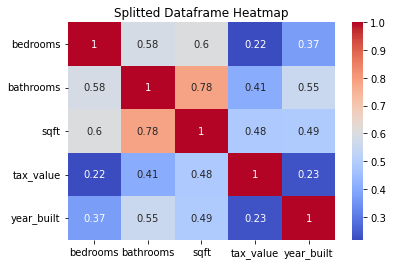

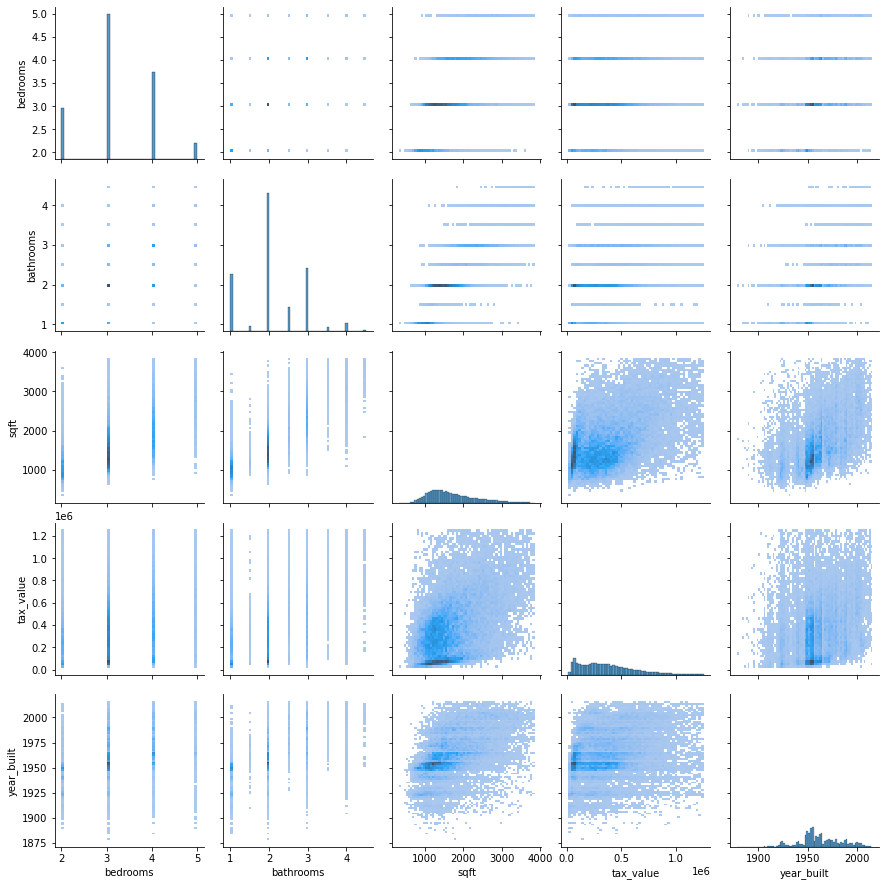

In [7]:
exploration_proc(train)

## Initial Questions

### 1. How does the tax_value relate to amount of bathrooms? What about bedrooms?

The charts below show that the more bedrooms and bathrooms the higher the tax value. They may be a few exeptions, like the value of 3.5 bathrooms is in average greater than 4 bathrooms. Having said that, the tax value mean trend, is to move up as there are more bedrooms and bathrooms.

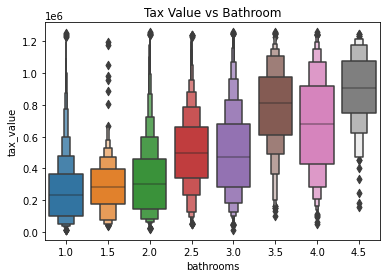

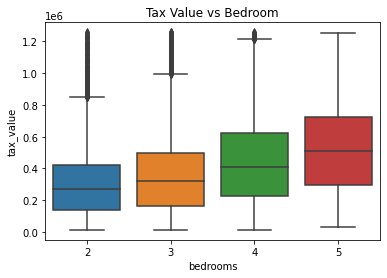

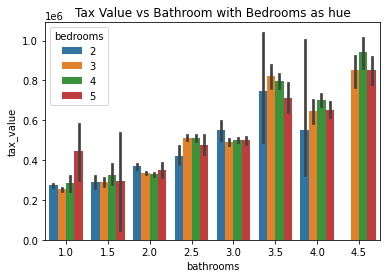

In [8]:
get_q1(train)

### 2. How does the tax_value relate construction age?

The chart below shows higher value as the years progresses. As with our previous question, there may be some exeptions, but the trend shows an upward on value as the house is newer.

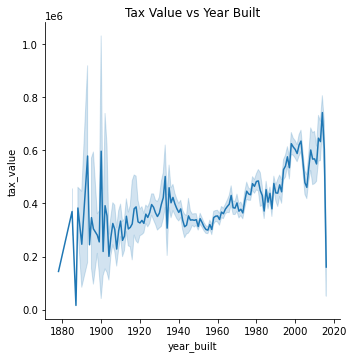

In [9]:
get_q2(train)

We can perform a chi2 to verify a correlation between Tax value and year built.
<p>
HO: There is no relation between Tax Value and Year Built
<p>
H⍺: There is a relation between Tax Value and Year Built

In [10]:
q2_stat_test(train)

HO: There is no relation between Tax Value and Year Built
H⍺: There is a relation between Tax Value and Year Built

Observed
:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------
Expected: 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------

chi2 = 2651342.16
p value: 0.0187
degrees of freedom: 2646553
We reject the null hypothesis


We can reject the null hypothesis so there is in fact a relationship between tax value and year built.

### 3. How does the tax value relate to house size?

Based on squared footage, the bigger it is the bigger the tax value. The charts below show a very high concentration of smaller houses to be most common.

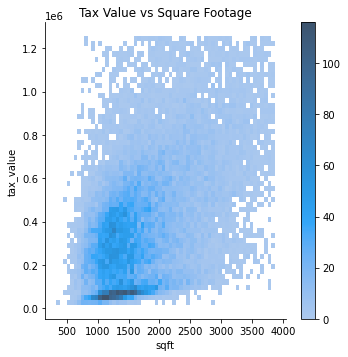

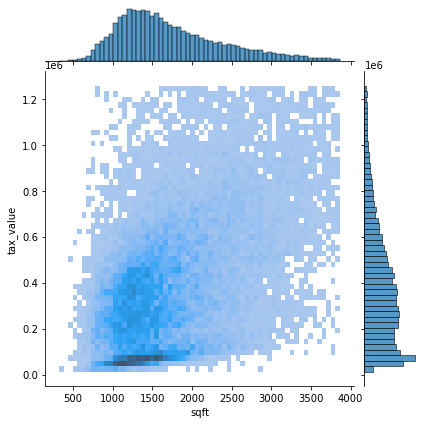

In [11]:
get_q3(train)

### 4. How does the tax value relate to location?

There are is a relation between the tax value and the location. 
Looking at the violin chart we can see: 
- the wide bottom on Los Angeles County 
- Ventura county gets wide around the 400k value  
- Orange county is wider around 800k - 1M

On the cat plot chart we can see:
- very few high value and a little less low value homes on Ventura
- Los Angeles County looks very consistent throughout all the prices 
- Orange County is consistent until about 1M 

Over all looking at both we can see changes based on county and there is some relation

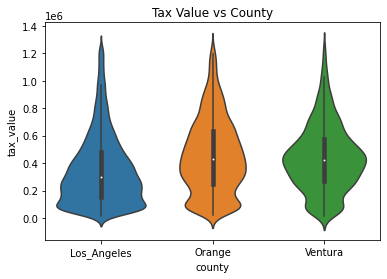

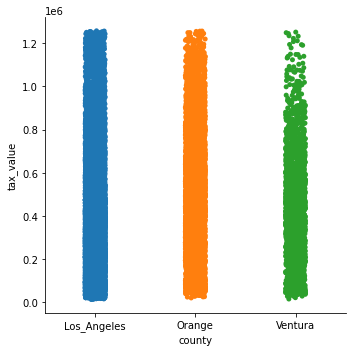

In [12]:
get_q4(train)

In [13]:
q4_stat_test(train)

HO: There is no relation between Tax Value and County
H⍺: There is a relation between Tax Value and County

Observed
:
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [1 0 0]]
------------------------
Expected: 

[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
------------------------

chi2 = 45104.30
p value: 0.0000
degrees of freedom: 41678
We reject the null hypothesis


We can reject the null hypothesis! So there is in fact a relationship between tax value and county where the home is.

## Data Modeling

### Drop categorical variables

In [14]:
train = train.drop(columns=['county', 'year_built'])
validate = validate.drop(columns=['county', 'year_built'])
test = test.drop(columns=['county', 'year_built'])

### Create X and Y variables

In [15]:
X_train = train.drop(columns=['tax_value'])
y_train = train[['tax_value']]

X_validate = validate.drop(columns=['tax_value'])
y_validate = validate[['tax_value']]

X_test = test.drop(columns=['tax_value'])
y_test = test[['tax_value']]

### Create a baseline

In [16]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict taxvalue_mean
taxvalue_pred_mean = y_train['tax_value'].mean()
y_train['taxvalue_pred_mean'] = taxvalue_pred_mean
y_validate['taxvalue_pred_mean'] = taxvalue_pred_mean

# 2. compute taxvalue_median
taxvalue_pred_median = y_train['tax_value'].median()
y_train['taxvalue_pred_median'] = taxvalue_pred_median
y_validate['taxvalue_pred_median'] = taxvalue_pred_median

# 3. RMSE of taxvalue_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.taxvalue_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.taxvalue_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of taxvalue_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.taxvalue_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.taxvalue_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  262435.17 
Validate/Out-of-Sample:  265189.74
RMSE using Median
Train/In-Sample:  266147.4 
Validate/Out-of-Sample:  269193.53


### TweedieRegressor (GLM)


In [19]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['taxvalue_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.taxvalue_pred_glm)**(1/2)

# predict validate
y_validate['taxvalue_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.taxvalue_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  262435.1694660326 
Validation/Out-of-Sample:  265189.74235114787


### Evaluate

In [20]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['taxvalue_pred_glm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.taxvalue_pred_glm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  231186.70174349454


## Conclusion

After reviewing the data:

- The key drivers of property value for single family properties, seem to be the square footage, number of bathrooms and number of bedrooms in that order.

- We were able to get wrangle the data, droped about 5700 outliers able to answer 4 questions about the tax value of the properties

- Constructed an ML Regression model, GLM, that predict propery tax assessed values of Single Family Properties using attributes of the properties.

- My recommendations is to continue obtaining pertinent information such as the three factors mentioned 

- With more time I would like to see what are the comparisons between states and make our model more accurate
